The survival function is

$$S(t)- F_T(t)=1-\left ( 1- e^{-\lambda t}  \right)=e^{-\lambda t} =e^{\text{Haz }t}$$

where $F_T(t)$ is the distribution of the exponential.

the rate $\lambda$ is the hazard, which is estimated as

$$\text{Haz}= e^{b_0 +b_1 X_1+\cdots+b_nX_n}$$

Alternatively,

$$\log(\text{Haz})= b_0 +b_1 X_1+\cdots+b_nX_n$$

$b_0$ is the log hazard for reference at $t=0.$

In the exponential model $b_0$ is a constant. In the Weibull, $'b_0'$ changes proportionally with time (accelerated failure):

$$'b_0'= \log(\alpha) +\log(t) +b_0.$$

In the Cox proportional hazard model, $b_0$ is a function of time:

$$b_0= \log(h_0(t))$$

$h_0(t)$ is the baseline hazard function. However the function needs not be specified, although at the expense of not being able to estimate the survival function (not a predictive model (estimating survival)). The model alloows us to calculate the other coefficients, and their hazard ratios: $e^{b_i},$ which tell us how survival is affected by each variable (effect size).

The kaplan-Meier can be predictive, but doesn't allow calculating hazard ratios.

The assumptions of the Cox HP model are:

1. Non-informative censoring (points censored are neither more or less likely to die. This is common to all other models. People who stay in the study are no different than those lost to follow up.
2. Survival times are independent. This is common to all other models.
3. Hazards are proportional (hazard ratios are constant over time - the hazards vary, but not the ratios, i.e. the lines do not cross). This can be tested with the log-log plot (looking for cross over of the curves or "megaphoning" out) and the Schoenfeld's test. This is also assumed in exponential and Weibull. If this is not fulfilled, the coefficients in the regression can be allowed to change over time by including interactions.
4. Log of the hazard is a linear function of the variables like in Poisson or logistic. Check with residual plots. This is also assumed in exponential and Weibull. Otherwise, the variables can be transformed or polynomial regression can be attempted.
5. Values of the dependent variables do not change over time. Remedied with time-dependent covariates model. Smokers remain smokers. There are time-updated Cox models.
6. Baseline hazard ($h_0$) is un-specified.

In [ ]:
options(repr.plot.width=7, repr.plot.height=7)

library(survival)
require(survival)
head(lung)

,inst,time,status,age,sex,ph.ecog,ph.karno,pat.karno,meal.cal,wt.loss
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,3,306,2,74,1,1,90,100,1175,NA
2,3,455,2,68,1,0,90,90,1225,15
3,3,1010,1,56,1,0,90,90,NA,15
4,5,210,2,57,1,1,90,60,1150,11
5,1,883,2,60,1,0,100,90,NA,0
6,12,1022,1,74,1,1,50,80,513,0


In [ ]:
lung$over55 <- ifelse(lung$age >= 55, 1, 0)
lung$status <- ifelse(lung$status == 1, 0, 1)
d <- lung[,c(2,3,11)]
head(d)
summary(d)

,time,status,over55
,<dbl>,<dbl>,<dbl>
1,306,1,1
2,455,1,1
3,1010,0,1
4,210,1,1
5,883,1,1
6,1022,0,1


      time            status           over55      
 Min.   :   5.0   Min.   :0.0000   Min.   :0.0000  
 1st Qu.: 166.8   1st Qu.:0.0000   1st Qu.:1.0000  
 Median : 255.5   Median :1.0000   Median :1.0000  
 Mean   : 305.2   Mean   :0.7237   Mean   :0.8114  
 3rd Qu.: 396.5   3rd Qu.:1.0000   3rd Qu.:1.0000  
 Max.   :1022.0   Max.   :1.0000   Max.   :1.0000  

Call: survfit(formula = Surv(d$time, d$status) ~ 1, type = "kaplan-meier")

      n  events  median 0.95LCL 0.95UCL 
    228     165     310     285     363 

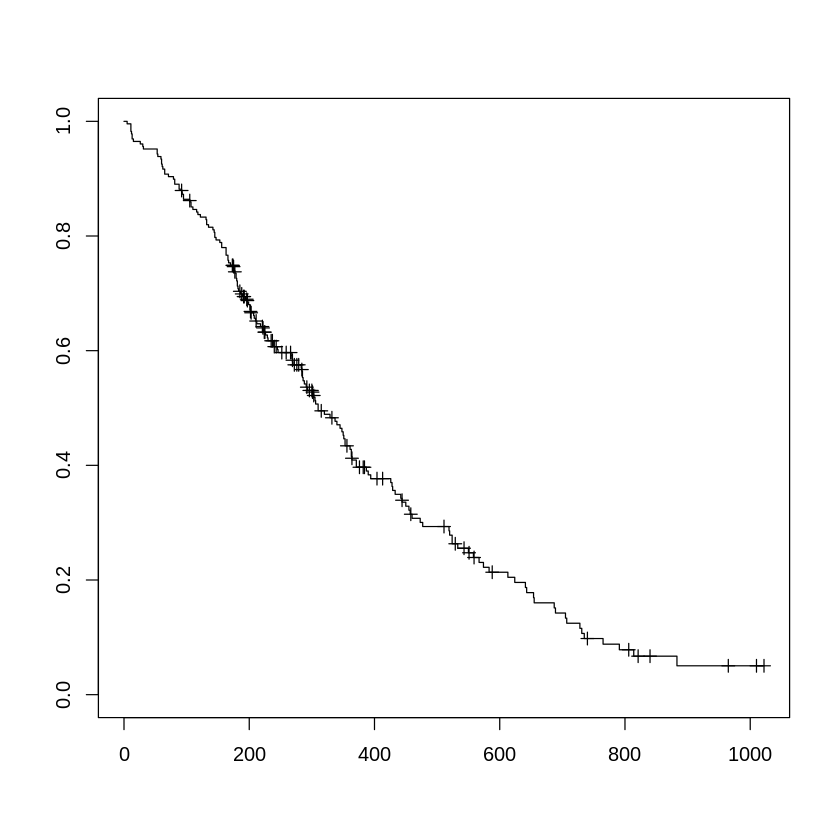

In [ ]:
m <- survfit(Surv(d$time,d$status) ~ 1,  type='kaplan-meier')
m
plot(m, mark.time=T, conf.int = F)

Call: survfit(formula = Surv(d$time, d$status) ~ d$over55, type = "kaplan-meier")

             n events median 0.95LCL 0.95UCL
d$over55=0  43     28    320     239     624
d$over55=1 185    137    310     283     363

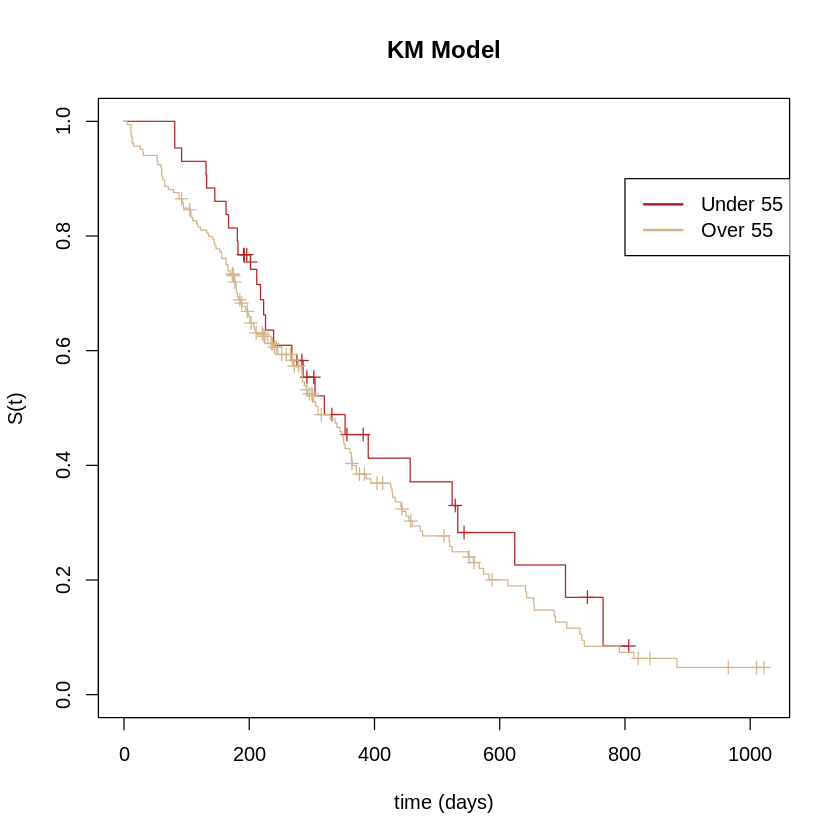

In [ ]:
mod <- survfit(Surv(d$time,d$status) ~ d$over55, type='kaplan-meier')
mod
plot(mod, mark.time=T, conf.int=F, col=c('firebrick','tan'), main='KM Model', ylab='S(t)', xlab='time (days)')
legend(800,0.9, legend=c('Under 55', 'Over 55'), col=c('firebrick','tan'), lty=1, lwd=2, bty='')

In [ ]:
# Log rank test:

survdiff(Surv(d$time,d$status) ~ d$over55,)

Call:
survdiff(formula = Surv(d$time, d$status) ~ d$over55)

             N Observed Expected (O-E)^2/E (O-E)^2/V
d$over55=0  43       28     32.8     0.710     0.893
d$over55=1 185      137    132.2     0.176     0.893

 Chisq= 0.9  on 1 degrees of freedom, p= 0.3 

H0: No differences in survival ($S(t)$) between groups.

Ha: Survival curves are different.

In the case above the groups are below and above 55 years of age.

It compares the number of deaths to the expected, much like a chi square test.

Limitations of the Kaplan-Meier method:

1. Only valid to stratify based on categorical variables ("above 55").
2. Can't incorporate many explanatory variables.
3. Non-parametric: no simpler way (as in coefficients of line) to summarize.

K-M is a good starting (exploratory) starting point.

The Cox proportional hazards model is semi-parametric. It does not assume a constant hazard (probability of dying now, given that you are alive - instantaneous risk of death). Because the hazard varies over time, there is no intercept (no baseline hazard). So we won't be able to estimate the hazard for an individual, just the hazard ratios (akin to odds ratio) between groups.

The hazard ratios are obtained by exponentiating coefficients. If the HR is greater than $1$ compared to the un-specified baseline hazard, the median survival will be shorter.

The coefficients in the output tell us the difference in the log-hazard function between groups (categorical) or the change in the log-hazard per one-unit change in $X$ (continuous).

In [ ]:
summary(survreg(Surv(time, status) ~ age+sex, data=lung, dist="exponential") )


Call:
survreg(formula = Surv(time, status) ~ age + sex, data = lung, 
    dist = "exponential")
               Value Std. Error     z      p
(Intercept)  6.35967    0.63547 10.01 <2e-16
age         -0.01562    0.00911 -1.72  0.086
sex          0.48093    0.16709  2.88  0.004

Scale fixed at 1 

Exponential distribution
Loglik(model)= -1156.1   Loglik(intercept only)= -1162.3
	Chisq= 12.48 on 2 degrees of freedom, p= 0.002 
Number of Newton-Raphson Iterations: 4 
n= 228 


In [ ]:
Stan <- na.omit(stanford2)
Stan <- Stan[order(Stan$t5),]
Stan$MisMatchLevel <- as.factor(c(rep(0,60),rep(1,53),rep(2,44)))
Stan <- Stan[order(Stan$age),]
colnames(Stan) <- c("ID", "Time", "Status", "Age", "t5Score", "MisMatchLevel")
Stan$Over40 <- as.factor(ifelse(Stan$Age >40, 1, 0))
Stan <- Stan[,c(1:4,7,5,6)]
names(Stan)

[1] "ID"            "Time"          "Status"        "Age"          
[5] "Over40"        "t5Score"       "MisMatchLevel"

In [ ]:
cox.mod <- coxph(Surv(Stan$Time,Stan$Status) ~ Stan$Over40 + Stan$MisMatchLevel)
summary(cox.mod)

Call:
coxph(formula = Surv(Stan$Time, Stan$Status) ~ Stan$Over40 + 
    Stan$MisMatchLevel)

  n= 157, number of events= 102 

                       coef exp(coef) se(coef)      z Pr(>|z|)  
Stan$Over401         0.5196    1.6813   0.2186  2.377   0.0175 *
Stan$MisMatchLevel1 -0.1813    0.8342   0.2389 -0.759   0.4480  
Stan$MisMatchLevel2  0.1106    1.1170   0.2414  0.458   0.6468  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

                    exp(coef) exp(-coef) lower .95 upper .95
Stan$Over401           1.6813     0.5948    1.0954     2.581
Stan$MisMatchLevel1    0.8342     1.1988    0.5223     1.332
Stan$MisMatchLevel2    1.1170     0.8953    0.6959     1.793

Concordance= 0.57  (se = 0.031 )
Likelihood ratio test= 7.47  on 3 df,   p=0.06
Wald test            = 7.08  on 3 df,   p=0.07
Score (logrank) test = 7.22  on 3 df,   p=0.07


The number of "events" is the number of deaths (below in the output).

Notice there is no intercept.

The `exp(coef)` are the **Hazard ratio**-s. For instance, at a given instant in time, someone over 40 years of age is `1.6813` times as likely to die as someone who is less than 40 years of age, adjusting for mismatch level. Now at a given instant in time, someone who is over 40 is  `1. 6813 - 1 = 68.13 %` as likley to die as someone who is under 40, adjusting for mismatch level.

The `exp(-coef)` is $1/\text{Hazard ratio},$ which would be the hazard ratio for under 40, rather than over 40.

The tests at the bottom test the null hypothesis that $\beta_1,\dots,\beta_n=0.$

The Concordance or C-statistic is a goodness-of-fit statistic for survival analysis, equivalent to AUC in logistic regression. Compares the concordance between surviving in real life to predicted survival according to the model. It's the percentage of *pairs of observations* that are concordant. If the model did random guesses, the concordance would be 50 percent.

In [ ]:
# Let's compare to another model, dropping a variable:

cox.mod2 <- coxph(Surv(Stan$Time,Stan$Status) ~ Stan$Over40)
summary(cox.mod2)

Call:
coxph(formula = Surv(Stan$Time, Stan$Status) ~ Stan$Over40)

  n= 157, number of events= 102 

               coef exp(coef) se(coef)     z Pr(>|z|)  
Stan$Over401 0.5228    1.6868   0.2185 2.393   0.0167 *
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

             exp(coef) exp(-coef) lower .95 upper .95
Stan$Over401     1.687     0.5929     1.099     2.588

Concordance= 0.551  (se = 0.027 )
Likelihood ratio test= 6.09  on 1 df,   p=0.01
Wald test            = 5.73  on 1 df,   p=0.02
Score (logrank) test = 5.85  on 1 df,   p=0.02


In both cases the standard error in the calculated coefficient for over 40 has remained around `0.2` with the coefficient remaining at `0.5`, indicating that the mismatch level was not acting as confounder to the primary explanatory variable (age). So it should be excluded.

In [ ]:
anova(cox.mod2, cox.mod, test='LRT') # Likelihood ratio test (LRT)

,loglik,Chisq,Df,P(>|Chi|)
,<dbl>,<dbl>,<int>,<dbl>
1,-448.0490,NA,NA,NA
2,-447.3578,1.382362,2,0.5009841


H0: There is no difference between models.

Ha: Full model explains more (larger predictive value).

It is a chi-square test.

Mismatched may not be a confounder, as seen from the analysis of the two models outputs, but *if* it were significant (it is NOT) despite what was discussed about the lack of change in the coefficient of the age predictor (or its SE), which indicates that mismatch is not a confounder, we would consider including mismatch in the final model to add precision (better model). In that case mismatch would be another significant predictor (although not a confounder).

In [ ]:
# What about a model with numeric predictors:

cox.num <- coxph(Surv(Stan$Time,Stan$Status) ~ Stan$Age + Stan$t5Score)
summary(cox.num)

Call:
coxph(formula = Surv(Stan$Time, Stan$Status) ~ Stan$Age + Stan$t5Score)

  n= 157, number of events= 102 

                coef exp(coef) se(coef)     z Pr(>|z|)   
Stan$Age     0.02961   1.03006  0.01136 2.608  0.00911 **
Stan$t5Score 0.17041   1.18579  0.18326 0.930  0.35243   
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

             exp(coef) exp(-coef) lower .95 upper .95
Stan$Age         1.030     0.9708     1.007     1.053
Stan$t5Score     1.186     0.8433     0.828     1.698

Concordance= 0.59  (se = 0.034 )
Likelihood ratio test= 8.47  on 2 df,   p=0.01
Wald test            = 7.81  on 2 df,   p=0.02
Score (logrank) test = 7.87  on 2 df,   p=0.02


At a given point in time the probability of dying for someone who is 1 year older is `1.03006` higher (3 percent) than someone who is 1 year younger, adjusting for `t5` score. This is statistically significant at $5$ percent, and that is why the CI does not include one for the exponentiated coefficients $(e^0=1).$

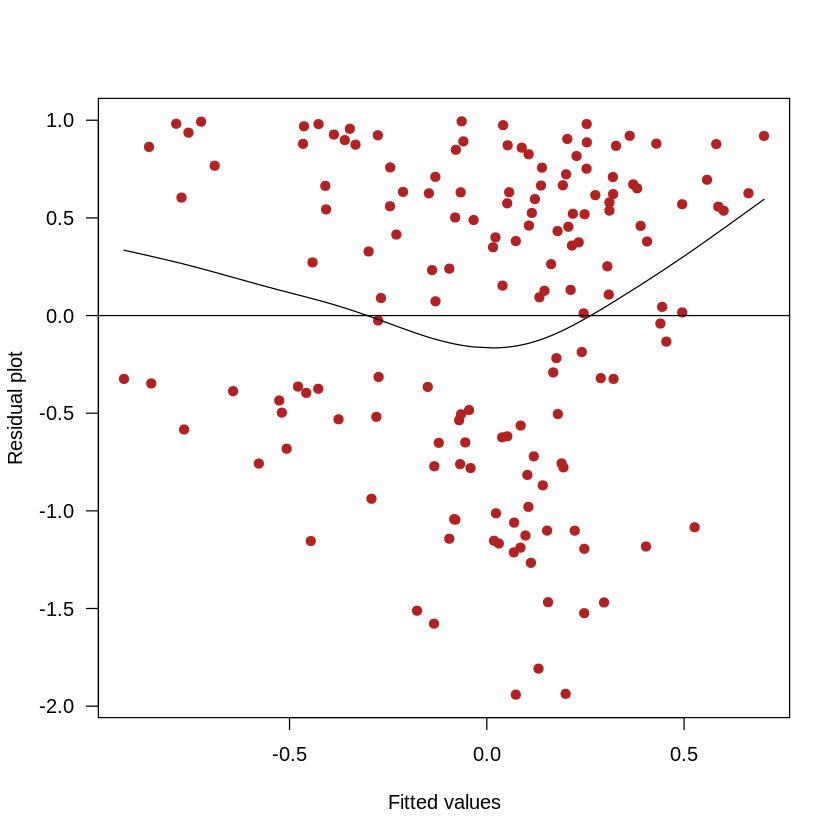

In [ ]:
# Check the linearity assumption:

plot(predict(cox.num), residuals(cox.num, type='martingale'),
      xlab='Fitted values', ylab= 'Residual plot', las=1, pch=19, col='firebrick')
abline(h=0)
lines(smooth.spline(predict(cox.num), residuals(cox.num, type='martingale')))

There is a bit of non-linearity. It can be addressed by identifying the variable that is non-linear, and transforming it, or using polynomials, etc.

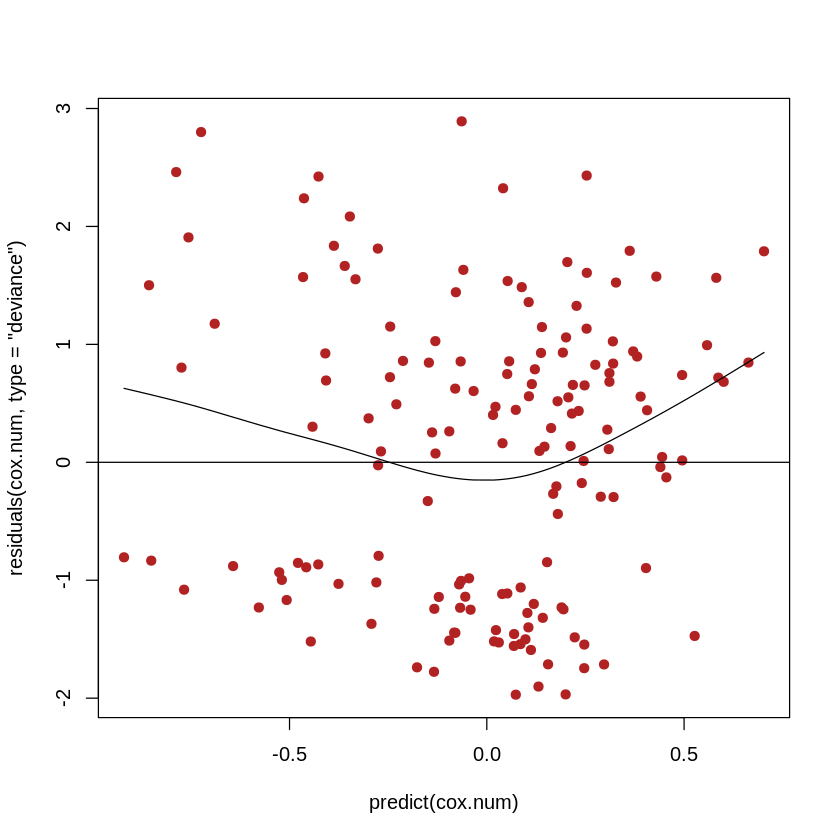

In [ ]:
# We can check the same plot using:

plot(predict(cox.num), residuals(cox.num, type='deviance'),
    pch=19, col='firebrick')
abline(h=0)
lines(smooth.spline(predict(cox.num), residuals(cox.num, type='deviance')))

The proportional hazards can be tested with the Schoenfeld test

H0: Hazards are proportional; Ha: Hazards are not proportional.

The p values are higher than 5 percent.

We can plot this test.

In [ ]:
cox.zph(cox.num)

             chisq df    p
Stan$Age      0.83  1 0.36
Stan$t5Score  2.06  1 0.15
GLOBAL        2.77  2 0.25

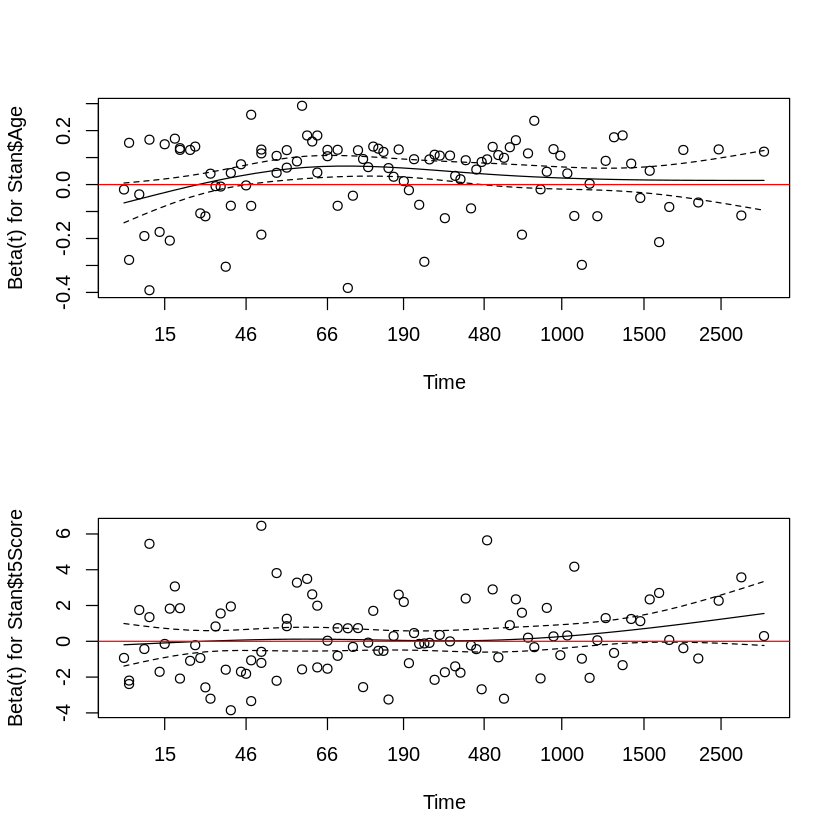

In [ ]:
par(mfrow=c(2,1))
plot(cox.zph(cox.num)[1])
abline(h=0,col=2)
plot(cox.zph(cox.num)[2])
abline(h=0,col=2)

The line tells us how the coefficient (or hazard ratio) would change over time if we allowed it to change. The dashed lines are a confidence bands. The zero change (in red) is sometimes within the interval, but not always in the first plot. So the assumption is a bit suspect.

The proportional hazard assumption is better in the second plot.